Thanh Truc Bui

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import optuna

import joblib

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [2]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [3]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [4]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [5]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [6]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [7]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [8]:
"""
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)
"""


'\ndef most_common_last_aa(seq_map:dict):\n    last_aa_list=dict()\n    for header in seq_map.keys():\n        last=seq_map[header].last_aa\n        if not last in last_aa_list:\n            last_aa_list[last] = 0\n        last_aa_list[last]+=1\n    common_aa=[]\n    for aa in last_aa_list.keys():\n        if not aa=="X":\n            if (last_aa_list[aa]/len(seq_map))>0.09:\n                common_aa.append(aa)\n                print (last_aa_list[aa]/len(seq_map))\n    return common_aa\n\nenzymes_common_last_aa=most_common_last_aa(enzymes_map)\nprint(enzymes_common_last_aa)\nnon_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)\nprint(non_enzymes_common_last_aa)\n'

The most common last amino acids are not significant and thus will be ignored

<font size="5">Looking for some kmers<font>

In [9]:
def hamming_distance(Genome1:str, Genome2:str):
    distance=0
    for i in range(len(Genome1)):
        if Genome1[i]!=Genome2[i]:
            distance+=1
    return distance

def neighbors(Pattern: str, d: int):
    if d==0:
        return [Pattern]
    
    if len(Pattern)==1:
        return ['A', 'C', 'G', 'T']
    
    neighborhood=[]
    suffix_neighbors=neighbors(Pattern[1:], d)
    for text in suffix_neighbors:
        if hamming_distance(Pattern[1:], text)<d:
            for x in ['A', 'C', 'G', 'T']:
                neighborhood.append(x+text)
        else:
            neighborhood.append(Pattern[0]+text)
    return neighborhood

def max_map(freq_map):
    max=0
    for key in freq_map.keys():
        if freq_map[key]>max:
            max=freq_map[key]
    return max

def kmer_with_max_d_mismatch(protein_map:dict(), k:int, d: int):
    Patterns=[]
    kmers_map=dict()

    for protein in protein_map.keys():
        Text=protein_map[protein].seq
        for i in range(len(Text)-k+1):
            Pattern=Text[i:i+k]
            neigherborhood=neighbors(Pattern, d)
            for j in range(len(neigherborhood)):    #Every neighbor of a pattern can be a key in the map. Now we find out which key has the highest value
                neighbor=neigherborhood[j]
                if not neighbor in kmers_map.keys():
                    kmers_map[neighbor]=1
                else:
                    kmers_map[neighbor]+=1
    
    m=max_map(kmers_map)
    for key in kmers_map.keys():
        if kmers_map[key]==m:
            Patterns.append(key)
    
    return Patterns


In [10]:
#kmer_with_max_d_mismatch(enzymes_map, 20, 1)


In [11]:
#kmer_with_max_d_mismatch(non_enzymes_map, 20, 1)


Pick the best n for the PCA

In [12]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.keys():
    embs_non_enzymes.append(non_enzymes_map[protein].embeddings)



In [13]:

def pick_n_for_pca(embs):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 2561, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    n_components_90_percent = np.argmax(y >= 0.90) + 1


    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='#ff7f00')

    plt.xlabel('Number of Components')
    plt.xticks([256,512,700,1024,2048,2560])    
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.90, color='#377eb8', linestyle='-')
    plt.text(0.8, 0.85, '90% cut-off threshold', color = '#377eb8', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    return n_components_90_percent


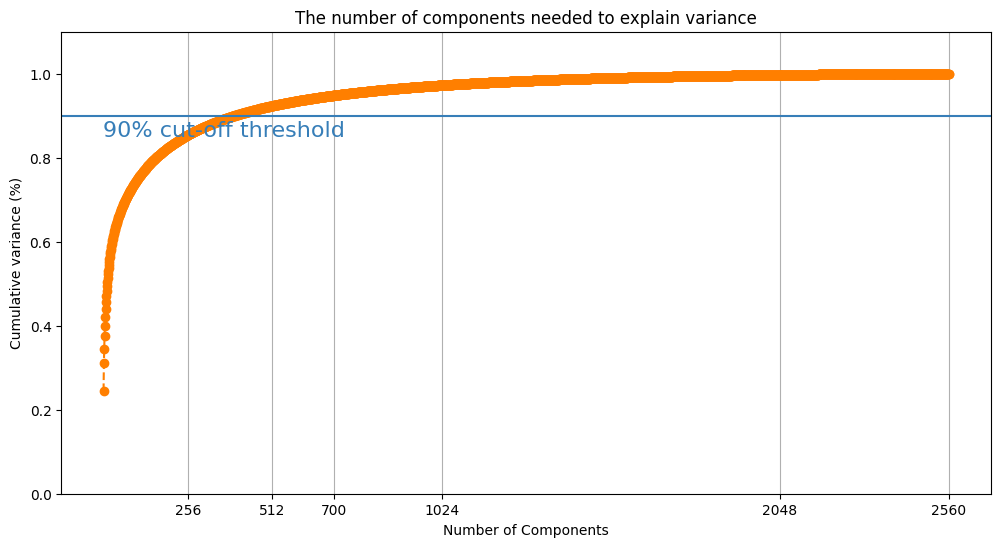

397

In [14]:

pick_n_for_pca(embs_enzymes)

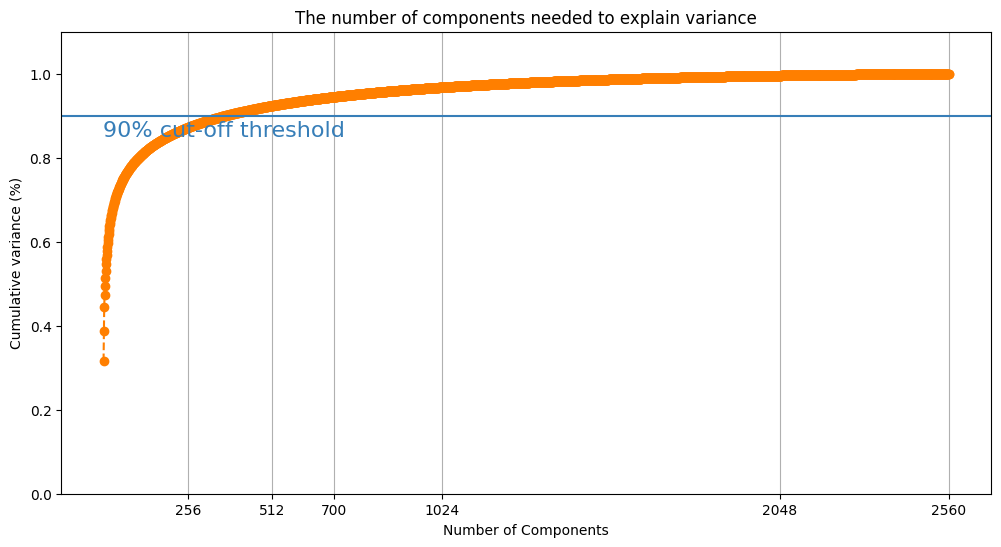

369

In [15]:
pick_n_for_pca(embs_non_enzymes)

Now that with n=700 we get 90% cut off, we choose PCA with 397 dimension

In [16]:
n_dimensions_after_pca=397

<font size="5">Create a dataframe<font>

In [17]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    seqs=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        seqs.append(entry.seq)
        
    emb_pca_all=PCA_for_emb(np.array(embs),n_dimensions_after_pca).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [18]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry        Mass  \
0          1  A0A024RBG1   20403.292   
1          1  A0A024SMV2   42741.490   
2          1  A0A060S684   63631.543   
3          1  A0A075TXZ3   61430.846   
4          1  A0A077K8G3   45202.778   
...      ...         ...         ...   
48701      0      X2JAU8  117164.590   
48702      0      X5HYT8   46670.171   
48703      0      X5LX76  118226.070   
48704      0      X6R8D5   14504.182   
48705      0      X6R8R1   52161.639   

                                                     Emb  Emb median  \
0      [-0.015143169, 0.035552002, -0.02231326, 0.002...   -0.003883   
1      [0.059097216, -0.034141198, 0.061426997, 0.006...   -0.002613   
2      [-0.016934631, -0.04490467, 0.0054878886, -0.0...   -0.002250   
3      [-0.06815035, -0.034723807, 0.03341713, -0.057...   -0.001353   
4      [-0.03639361, 0.046453245, 0.06140146, -0.0697...   -0.004369   
...                                                  ...         ...   
48701  [-0.0968

In [19]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_esm2_df.csv', index = False)

PCA -> df

In [20]:
for i in range(n_dimensions_after_pca):
    df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
df

/tmp/ipykernel_16337/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_16337/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_16337/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.7201104760169983, 0.14486804604530334, 0.3...",-0.720110,0.144868,...,-0.042683,0.046193,0.029641,-0.028887,0.060631,0.030718,-0.011295,0.002798,-0.006359,0.026551
1,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059980511665344, -0....",1.113257,-0.090600,...,-0.049887,0.057595,0.027914,0.037530,-0.050364,-0.037360,-0.004850,-0.000900,0.031191,0.027607
2,1,A0A060S684,63631.543,"[-0.016934631, -0.04490467, 0.0054878886, -0.0...",-0.002250,0.238975,12.091348,"[-0.14153915643692017, -0.1662549078464508, -0...",-0.141539,-0.166255,...,0.050905,-0.057045,-0.032793,0.016910,-0.060135,0.021541,-0.005655,0.007681,0.042019,-0.026310
3,1,A0A075TXZ3,61430.846,"[-0.06815035, -0.034723807, 0.03341713, -0.057...",-0.001353,0.235385,11.909699,"[0.20521371066570282, -0.25431257486343384, -0...",0.205214,-0.254313,...,0.053910,-0.055722,-0.034398,0.016961,-0.065796,0.019849,0.007285,0.028189,0.015759,-0.052438
4,1,A0A077K8G3,45202.778,"[-0.03639361, 0.046453245, 0.06140146, -0.0697...",-0.004369,0.246203,12.457084,"[-0.11231597512960434, 0.19396154582500458, 0....",-0.112316,0.193962,...,0.037519,0.083253,0.007753,-0.007725,0.049810,0.008225,-0.008143,0.016376,0.006249,-0.040639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48701,0,X2JAU8,117164.590,"[-0.09689512, -0.090523794, -0.016701577, -0.0...",-0.003210,0.218149,11.037591,"[3.928795099258423, 1.0540283918380737, 0.0701...",3.928795,1.054028,...,0.033985,0.031722,-0.055334,-0.011045,-0.072925,0.026282,0.016924,0.038277,0.019474,0.002990
48702,0,X5HYT8,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071576356887817, 0.28157445788383484, 0.4...",-0.807158,0.281574,...,0.015156,-0.001310,-0.004618,0.000358,0.003375,-0.004112,-0.000477,0.067068,-0.007490,0.005286
48703,0,X5LX76,118226.070,"[-0.0035375275, -0.021880746, -0.028436316, 0....",-0.003806,0.255798,12.942582,"[0.0361865758895874, -0.42618587613105774, -0....",0.036187,-0.426186,...,-0.000161,-0.020837,0.021399,-0.021548,0.018769,-0.008314,-0.006962,0.038804,-0.039918,0.046515
48704,0,X6R8D5,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.694007635116577, 2.3132083415985107, 0.503...",-2.694008,2.313208,...,-0.014547,0.036936,0.029790,0.036746,0.005665,-0.020027,-0.002456,0.012341,-0.017066,0.034164


In [21]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30__and_non_enzymes_with_esm2_and_PCA_df.csv', index = False)

In [22]:
df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30__and_non_enzymes_with_esm2_and_PCA_df.csv')

Split data into training and validation sets

In [40]:
#Define the features and output:
y = df['Label']
# use 397 PCA components, mass and Emb magnitude as features 

X = df.drop(['Label','Entry','Emb','Emb PCA'],axis=1)

# X = df.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Mass', 'Emb magnitude']]

#Split data into train an test, with test size of 33%%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=42)


Features selection

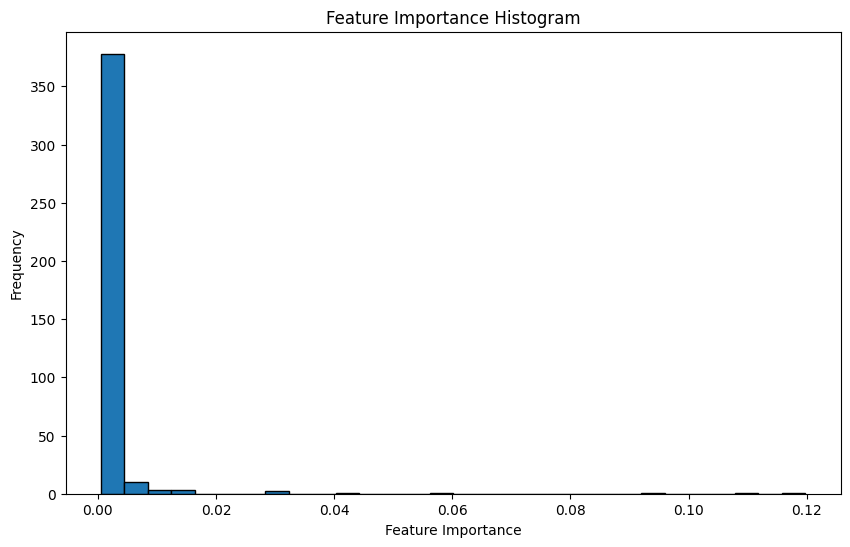

In [41]:
# Create a RandomForestClassifier with the desired parameters
clf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=16, min_samples_leaf=8)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Create a SelectFromModel instance with the trained classifier
sel = SelectFromModel(clf)

# Fit the SelectFromModel to your training data
sel.fit(X_train, y_train)

# Get the support for the selected features
selected_feat = X_train.columns[sel.get_support()]

# Get the feature importances
importances = clf.feature_importances_

# Create a histogram of feature importances
plt.figure(figsize=(10, 6))
plt.hist(importances, bins=30, edgecolor='k')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('Feature Importance Histogram')
plt.show()


Update X_train and X_test

In [48]:
selected_feat

Index(['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 31', 'PCA 32',
       'PCA 33', 'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47'],
      dtype='object')

In [49]:
X_train=X_train[selected_feat]
X_train

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
42738,68677.417,-0.002388,0.255592,12.932137,0.584779,-0.326472,0.070805,0.005981,-0.024380,-0.398041,...,0.071319,-0.159085,-0.156032,-0.062271,0.054652,0.081165,0.134481,-0.151484,-0.086550,-0.073069
33829,35941.722,-0.003355,0.252100,12.755472,0.496581,0.247560,0.325692,-0.059740,-0.101547,-0.328558,...,0.094877,-0.301803,-0.254907,-0.175584,-0.052964,0.007556,-0.020354,-0.248592,0.079230,-0.018438
9838,59488.012,-0.002860,0.225605,11.414863,2.145234,0.067071,-0.669973,-0.412324,0.232453,0.348689,...,-0.146641,-0.015153,-0.186331,-0.058871,0.020899,0.150501,0.149109,-0.002249,-0.000418,-0.006943
12019,9521.591,-0.003349,0.260375,13.174243,-0.160224,-0.434003,-0.770695,0.045688,-0.339789,-0.292375,...,-0.441752,-0.058041,-0.143148,0.001140,-0.025379,0.103792,-0.128165,-0.047641,-0.005095,0.071025
47488,184037.944,-0.002751,0.268325,13.576423,-0.242264,-0.955745,0.423105,0.013660,0.267741,0.472030,...,0.318372,0.065932,-0.044196,-0.010792,-0.089985,-0.083108,-0.063483,0.152082,0.078335,0.059425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1207.671,-0.001800,0.274221,13.874771,0.332582,-0.426886,1.361787,0.263855,0.505997,-0.817766,...,0.074596,0.020153,0.181713,-0.142887,0.028278,0.125050,-0.219555,0.018212,0.082925,-0.121958
44732,11011.811,-0.003975,0.262046,13.258679,0.842327,-0.478657,1.157194,0.159494,0.390672,-0.044826,...,-0.217268,0.016653,0.031655,0.131570,-0.025272,0.123562,0.090420,-0.125070,-0.080838,0.201391
38158,65315.096,-0.004251,0.286417,14.491904,-2.227549,0.590931,0.967998,-0.536130,-0.307147,0.864703,...,0.232471,0.060327,0.227705,0.185980,-0.220116,-0.065764,-0.038765,-0.295071,0.003466,-0.087755
860,39507.175,-0.004268,0.227770,11.524400,1.324473,-0.121696,-0.079244,0.418809,0.021612,-0.275153,...,-0.126811,-0.183515,0.186965,0.135588,0.140674,0.116277,0.035247,-0.023451,-0.019862,-0.119069


In [50]:
X_test=X_test[selected_feat]
X_test

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
31029,84179.927,-0.005188,0.280315,14.183102,-1.079622,-0.786357,-0.395571,0.384557,-0.300439,-0.694009,...,0.155455,-0.071542,0.083109,0.101390,-0.211982,0.303604,0.052331,-0.060692,0.066701,0.028406
9163,40015.929,-0.003720,0.247662,12.530894,0.066576,0.130817,0.606092,0.793578,-0.191410,0.157918,...,-0.104434,-0.042150,0.287715,-0.161174,-0.163789,0.182794,-0.258815,0.054243,-0.024895,-0.034413
44218,25748.422,-0.003732,0.249692,12.633614,1.392095,-0.092252,-0.017594,1.025021,-0.352417,-0.097878,...,0.127020,0.094718,0.157107,-0.088061,0.192112,-0.082333,0.230876,-0.116690,-0.030688,0.044449
29292,14118.559,-0.003815,0.288331,14.588769,-2.874705,2.369591,0.299459,-0.306645,0.236936,-0.202652,...,0.161220,0.246223,0.216341,-0.121118,0.027839,0.093639,-0.011763,0.299066,-0.059174,0.121125
27630,46896.832,-0.001844,0.230164,11.645526,1.698796,0.191818,-0.462934,-0.582283,0.365985,-0.024600,...,0.238796,0.141905,-0.176534,0.238059,-0.142407,0.014770,0.001735,-0.132584,-0.034162,-0.148646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23539,46302.659,-0.003184,0.256494,12.977774,0.144443,-0.360065,-0.713367,0.334952,-0.098395,-0.159220,...,-0.099534,-0.134784,0.185114,0.151700,-0.029104,-0.049972,0.093779,0.065874,0.043164,0.139088
43529,170467.001,-0.002230,0.243345,12.312482,1.691059,0.127002,0.261035,1.022140,-0.123688,-0.064369,...,0.261875,-0.067400,0.045287,-0.180702,-0.090605,-0.015436,-0.012865,0.132403,0.176121,0.123246
44891,58848.481,-0.003693,0.244300,12.360844,1.070305,-0.092692,-0.356335,0.007055,-0.205527,-0.537245,...,0.074883,0.184628,-0.145687,0.091692,-0.048748,0.038584,-0.064316,-0.014890,0.027437,0.152422
38792,50644.847,-0.004073,0.256159,12.960850,-0.092058,-0.350704,-1.094933,0.227885,0.560773,-0.523641,...,0.021594,-0.016930,0.123002,0.037936,0.113071,-0.067240,-0.030011,0.102481,-0.097286,-0.004420


Duplicate the enzymes class to achieve a balanced dataframe

In [51]:
train_df = pd.concat([y_train, X_train], axis=1)
to_be_dupped = train_df['Label'] == 1

# Duplicate rows with label 1 and keep other rows unchanged
train_df_dup = pd.concat([train_df[to_be_dupped]] * 3, ignore_index=True)

# Concatenate rows with label 1 repeated four times with the original data
train_df_dup = pd.concat([train_df, train_df_dup], ignore_index=True)

# Split the data again into X_train_dup and y_train_dup
train_df_dup = train_df_dup.sort_values(by=['Label','Mass'], ascending=[False, True]).reset_index(drop=True)
y_train_dup = train_df_dup['Label']
X_train_dup = train_df_dup.drop(['Label'], axis=1)


In [52]:
train_df_dup

,Label,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,...,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
0,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
1,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
2,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
3,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
4,1,1807.104,-0.003616,0.278597,14.096272,-1.676046,-0.885849,-0.280731,0.389827,-1.206279,...,0.343473,0.217043,0.331611,0.072711,0.048417,0.158590,0.157398,-0.005628,-0.361537,-0.043870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53253,0,801392.933,-0.004548,0.291113,14.729477,-2.267000,0.220507,-0.010475,0.794914,0.123339,...,-0.181228,0.110955,-0.048232,-0.141170,0.152229,0.003774,0.120240,-0.154734,-0.052081,0.173577
53254,0,893681.916,-0.003486,0.247288,12.511958,1.004709,-0.503609,0.032783,-0.084078,0.370209,...,0.395936,0.258318,-0.088671,0.047451,-0.193168,-0.129978,-0.145567,0.112790,0.026195,-0.042931
53255,0,1010437.522,-0.002775,0.268844,13.602712,-0.411011,-0.607820,0.053132,0.175375,-0.673853,...,0.314717,0.064135,-0.180257,-0.118660,0.077761,0.037840,-0.113666,0.015781,0.038614,-0.119082
53256,0,1050135.477,-0.001280,0.261026,13.207062,0.529047,-1.051051,-0.102947,0.154647,0.561211,...,0.279095,-0.134877,-0.316781,-0.093996,0.005091,0.038365,-0.017708,-0.037891,-0.158456,0.199940


In [53]:
y_train_dup

0        1
1        1
2        1
3        1
4        1
        ..
53253    0
53254    0
53255    0
53256    0
53257    0
Name: Label, Length: 53258, dtype: int64

In [54]:
X_train_dup

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
0,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,-0.092935,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,-0.092935,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
2,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,-0.092935,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
3,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491552,1.920415,-1.074927,0.318986,-0.092935,...,0.067748,0.105685,-0.045171,0.324120,-0.150518,0.255347,0.097113,-0.244102,-0.370304,0.160140
4,1807.104,-0.003616,0.278597,14.096272,-1.676046,-0.885849,-0.280731,0.389827,-1.206279,-0.176397,...,0.343473,0.217043,0.331611,0.072711,0.048417,0.158590,0.157398,-0.005628,-0.361537,-0.043870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53253,801392.933,-0.004548,0.291113,14.729477,-2.267000,0.220507,-0.010475,0.794914,0.123339,0.215139,...,-0.181228,0.110955,-0.048232,-0.141170,0.152229,0.003774,0.120240,-0.154734,-0.052081,0.173577
53254,893681.916,-0.003486,0.247288,12.511958,1.004709,-0.503609,0.032783,-0.084078,0.370209,0.463534,...,0.395936,0.258318,-0.088671,0.047451,-0.193168,-0.129978,-0.145567,0.112790,0.026195,-0.042931
53255,1010437.522,-0.002775,0.268844,13.602712,-0.411011,-0.607820,0.053132,0.175375,-0.673853,-0.142629,...,0.314717,0.064135,-0.180257,-0.118660,0.077761,0.037840,-0.113666,0.015781,0.038614,-0.119082
53256,1050135.477,-0.001280,0.261026,13.207062,0.529047,-1.051051,-0.102947,0.154647,0.561211,0.472438,...,0.279095,-0.134877,-0.316781,-0.093996,0.005091,0.038365,-0.017708,-0.037891,-0.158456,0.199940


Using Optuna for hyperparameter tuning

In [37]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 8, 128, step=10),
    }
    clf_optuna = RandomForestClassifier(**param)
    return cross_val_score(
        clf_optuna, X_train, y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2023-10-24 20:59:45,251] A new study created in memory with name: no-name-c533d1c2-084f-455e-9f73-78ed41def805
[I 2023-10-24 20:59:53,574] Trial 0 finished with value: 0.8884554069398097 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 118}. Best is trial 0 with value: 0.8884554069398097.
[I 2023-10-24 21:00:37,640] Trial 1 finished with value: 0.9614888008581527 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9614888008581527.
[I 2023-10-24 21:01:23,772] Trial 2 finished with value: 0.9357658134643461 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 118}. Best is trial 1 with value: 0.9614888008581527.
[I 2023-10-24 21:01:49,389] Trial 3 finished with value: 0.8152460522055199 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_leaf': 38}. Best is trial 1 with value: 0.9614888008581527.
[I 2023-10-24 21:02:04,708] Trial 4 finished with value: 0.859887419868

Accuracy: 0.9833108352704586
Best hyperparameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_leaf': 8}


In [55]:

#Build the model:
rf = RandomForestClassifier(max_depth=16, min_samples_leaf=8,n_estimators=200, random_state=42)


In [56]:
rf.fit(X_train_dup, y_train_dup)
y_pred=rf.predict(X_test)

<font size="5">Evaluate the model</font>

In [57]:
y_test=y_test.reset_index(drop=True)


0        0
1        1
2        0
3        0
4        0
        ..
14607    0
14608    0
14609    0
14610    0
14611    0
Name: Label, Length: 14612, dtype: int64

In [71]:
y_test.to_csv(r'/home/trucbui/PBLGit/random_forest/y_val.csv', index = False)
X_test.to_csv(r'/home/trucbui/PBLGit/random_forest/X_val.csv', index = False)

In [58]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

Calculate Standard Error

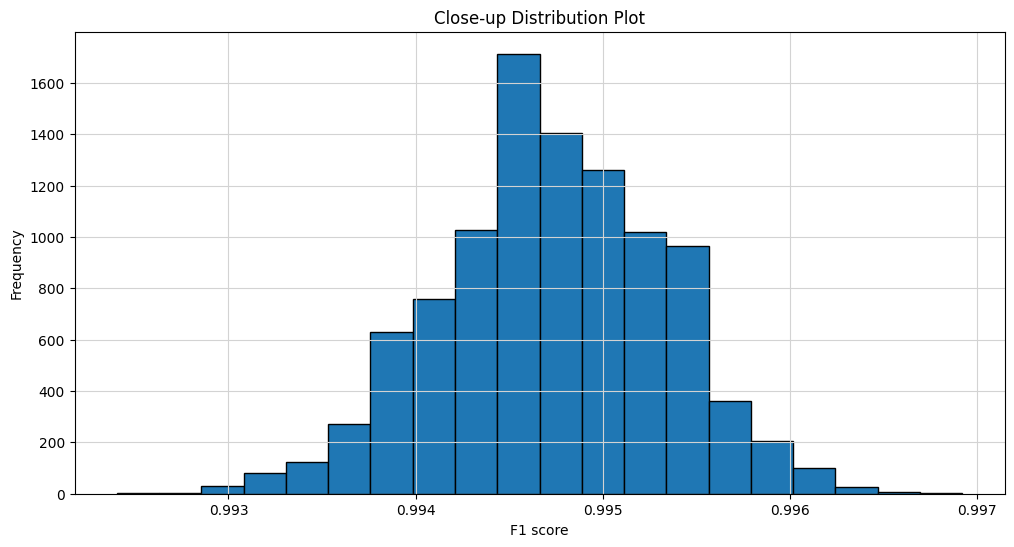

 Binary Classification Random Forest:
  - Initial F1 Score: 0.99
  - Mean ± SE: 0.9947 ± 0.00059
  - 95% CI: [0.99, 1.00]


In [59]:
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.9
    max_value = 1.0

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


initial_f1 = calculate_f1(y_test, y_pred)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, y_pred, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f" Binary Classification Random Forest:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")


In [60]:
# Generate random baseline predictions
n_samples = len(y_test)
random_baseline_predictions = np.random.choice(y_test, n_samples)

# Calculate the accuracy of the random baseline predictions
baseline_accuracy = accuracy_score(y_test, random_baseline_predictions)

print("Baseline Accuracy (Random Guessing):", baseline_accuracy)
print("Model accuracy: %f" % accuracy_score(y_test, y_pred))

Baseline Accuracy (Random Guessing): 0.6902545852723788
Model accuracy: 0.994730


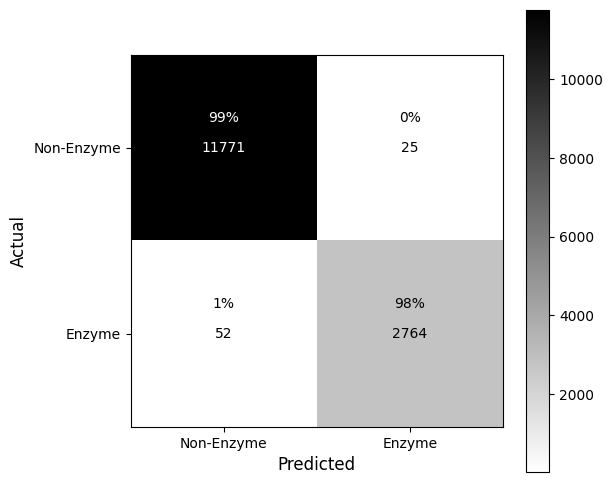

In [61]:
class_names = ["Non-Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)

plt.show()


In [62]:
f1 = f1_score(y_test, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall = {recall}")


F1 score: 0.9862622658340767
MCC score: 0.9830197330083605
Precision = 0.9910362136966655
Recall = 0.9815340909090909


<font size="5">Make a tree</font>

In [64]:
rf_3 = RandomForestClassifier(max_depth=3, min_samples_leaf=8,n_estimators=200, random_state=42)
rf_3.fit(X_train_dup, y_train_dup)

tree = rf_3.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot', feature_names = X_train.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file(r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot')
# Write graph to a png file:
graph.write_png(r'/home/trucbui/PBLGit/random_forest/tree_rf_esm2.png')

In [65]:
y_pred_rf3=rf_3.predict(X_test)
f1 = f1_score(y_test, y_pred_rf3, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred_rf3)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred_rf3)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred_rf3)
print(f"Recall = {recall}")


F1 score: 0.564398752454661
MCC score: 0.4666090395095951
Precision = 0.41825029960623183
Recall = 0.8675426136363636


<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9997229475419249


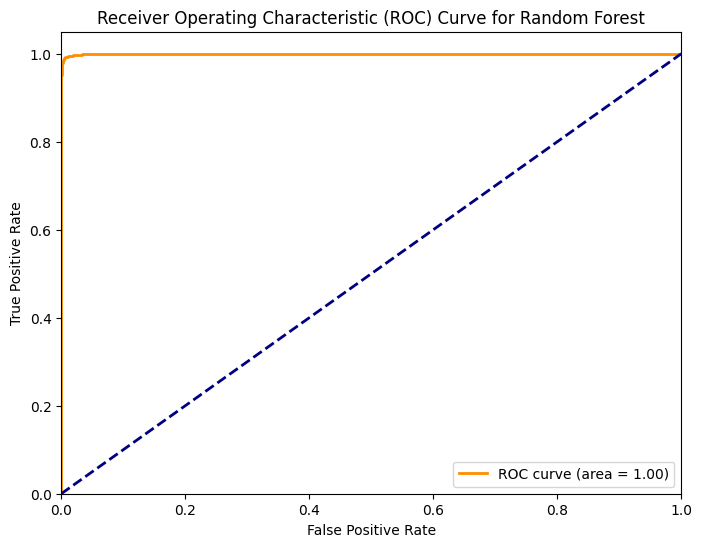

In [66]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

<font size="5">Save the model</font>

In [69]:
# file name, I'm using *.joblib as a file extension
filename = "/home/trucbui/PBLGit/random_forest/random_forest_esm2.joblib"

# save model
joblib.dump(rf, filename)


['/home/trucbui/PBLGit/random_forest/random_forest_esm2.joblib']

In [70]:

# load model
loaded_model = joblib.load(filename)

# you can use loaded model to compute predictions
y_predicted = loaded_model.predict(X_test)
loaded_model_accuracy = loaded_model.score(X_test, y_test)

print("Loaded Model Accuracy:" , loaded_model_accuracy * 100 , "%")


Loaded Model Accuracy: 99.47303586093622 %
